In [ ]:
from pyspark.sql import SparkSession

# Inicializa a sessão Spark
spark = SparkSession.builder \
    .appName("FraudDetection") \
    .getOrCreate()

# Carrega o dataset (header - para pegar primeira linha como cabeçalho, inferSchema - para inferir o tipo de dado de cada coluna)
df = spark.read.csv("dataset/Final-Transactions.csv", header=True, inferSchema=True)

# Exibe o esquema e as primeiras linhas do DataFrame
df.printSchema()
df.show(5)


root
 |-- _c0: integer (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)
 |-- TX_DATETIME: timestamp (nullable = true)
 |-- CUSTOMER_ID: integer (nullable = true)
 |-- TERMINAL_ID: integer (nullable = true)
 |-- TX_AMOUNT: double (nullable = true)
 |-- TX_TIME_SECONDS: integer (nullable = true)
 |-- TX_TIME_DAYS: integer (nullable = true)
 |-- TX_FRAUD: integer (nullable = true)
 |-- TX_FRAUD_SCENARIO: integer (nullable = true)

+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|_c0|TRANSACTION_ID|        TX_DATETIME|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_FRAUD_SCENARIO|
+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|  0|             0|2023-01-01 00:00:31|        596|       3156|   533.07|             31|           0|       0|                0|
|  1|             1|2023-01-

+--------+-------+
|TX_FRAUD|  count|
+--------+-------+
|       1| 235969|
|       0|1518186|
+--------+-------+



C:\Users\pedro\AppData\Local\Temp\ipykernel_10036\924738383.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TX_FRAUD', y='count', data=pandas_counts, palette="Set2")


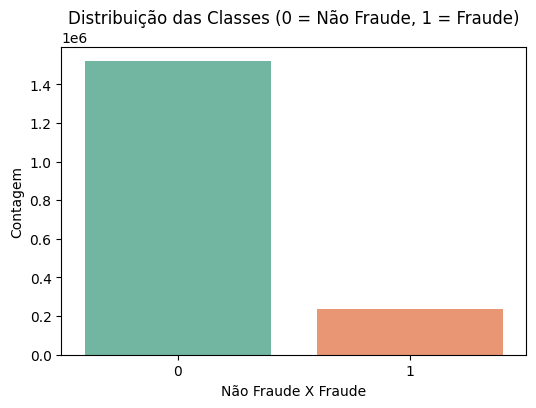

In [14]:
# Contagem de transações por classe (0 = Não Fraude, 1 = Fraude)
class_counts = df.groupBy("TX_FRAUD").count()
class_counts.show()

# Converte para Pandas para visualizar com gráficos
pandas_counts = class_counts.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(x='TX_FRAUD', y='count', data=pandas_counts, palette="Set2")
plt.title("Distribuição das Classes (0 = Não Fraude, 1 = Fraude)")
plt.xlabel("Não Fraude X Fraude")
plt.ylabel("Contagem")
plt.show()


#### Observação: Devido ao baixo número de fraudes, a distribuição do "TX_AMOUNT" pode mostrar variações específicas.

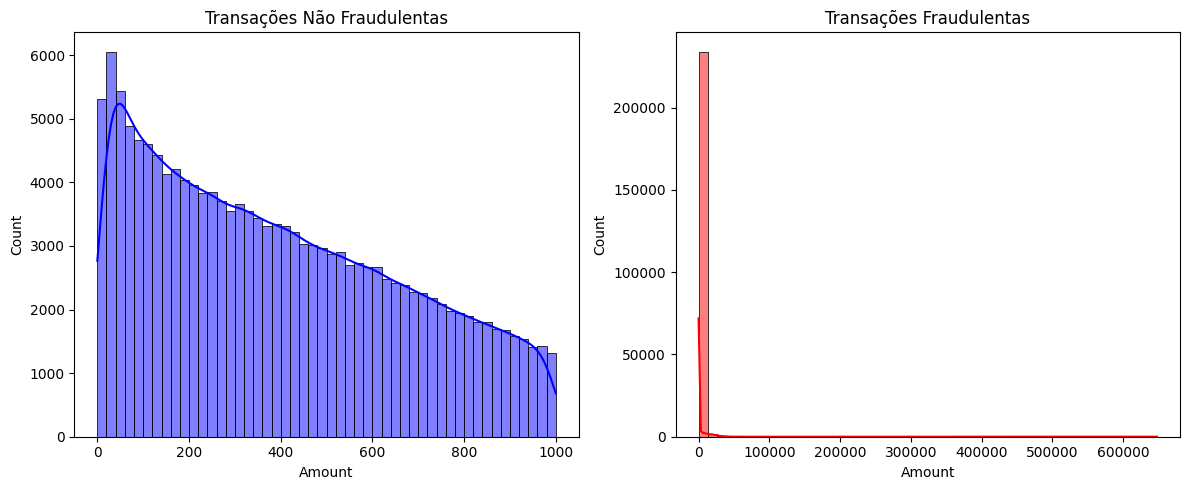

In [18]:
# Para transações não fraudulentas, amostramos 10% dos dados
nonfraud_pd = df.filter(df.TX_FRAUD == 0).select("TX_AMOUNT").sample(fraction=0.1, seed=42).toPandas()

# Para transações fraudulentas (sendo poucas), coletamos todos os registros
fraud_pd = df.filter(df.TX_FRAUD == 1).select("TX_AMOUNT").toPandas()

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.histplot(nonfraud_pd['TX_AMOUNT'], bins=50, color="blue", kde=True)
plt.title("Transações Não Fraudulentas")
plt.xlabel("Amount")

plt.subplot(1, 2, 2)
sns.histplot(fraud_pd['TX_AMOUNT'], bins=50, color="red", kde=True)
plt.title("Transações Fraudulentas")
plt.xlabel("Amount")
plt.tight_layout()
plt.show()


#### Eixo X: Valor da transação (Amount).
#### Eixo Y: Quantidade (contagem) de transações ocorrendo em cada faixa de valor.
##### Gráfico da esquerda (azul): Distribuição de valores para transações não fraudulentas.
##### Gráfico da direita (vermelho): Distribuição de valores para transações fraudulentas.
##### Esses gráficos mostram se as fraudes tendem a ocorrer em valores menores ou maiores em comparação às transações legítimas, ou se há uma concentração em faixas específicas de valor.

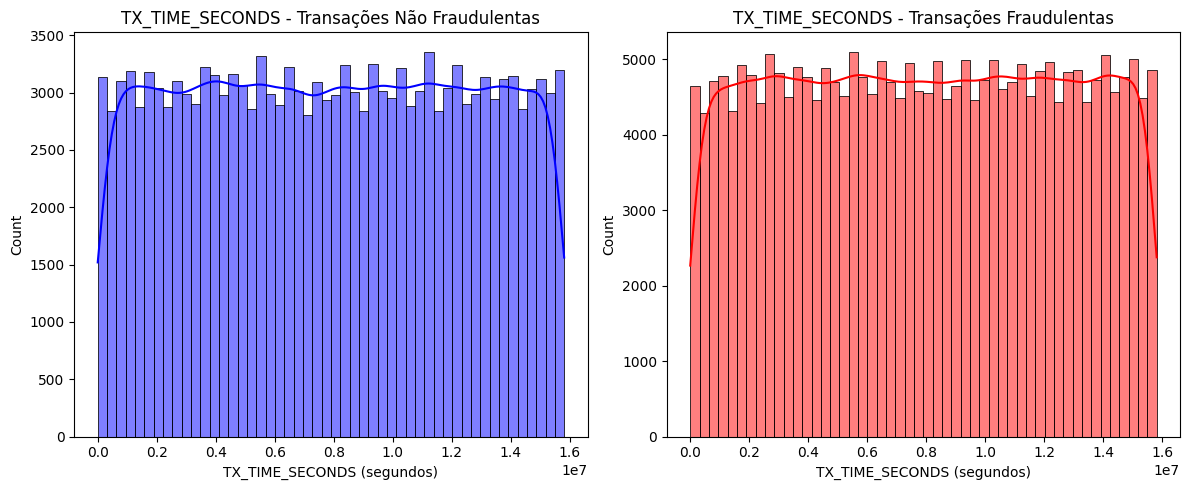

In [20]:
# Análise similar para a variável 'TX_TIME_SECONDS'
nonfraud_time = df.filter(df.TX_FRAUD == 0).select("TX_TIME_SECONDS").sample(fraction=0.1, seed=42).toPandas()
fraud_time = df.filter(df.TX_FRAUD == 1).select("TX_TIME_SECONDS").toPandas()

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.histplot(nonfraud_time['TX_TIME_SECONDS'], bins=50, color="blue", kde=True)
plt.title("TX_TIME_SECONDS - Transações Não Fraudulentas")
plt.xlabel("TX_TIME_SECONDS (segundos)")

plt.subplot(1, 2, 2)
sns.histplot(fraud_time['TX_TIME_SECONDS'], bins=50, color="red", kde=True)
plt.title("TX_TIME_SECONDS - Transações Fraudulentas")
plt.xlabel("TX_TIME_SECONDS (segundos)")
plt.tight_layout()
plt.show()

#### Eixo X: Tempo da transação em segundos (TX_TIME_SECONDS).
#### Eixo Y: Quantidade (contagem) de transações ocorrendo naquele intervalo de tempo.
##### Gráfico da esquerda (azul): Distribuição de transações não fraudulentas ao longo do tempo.
##### Gráfico da direita (vermelho): Distribuição de transações fraudulentas ao longo do tempo.
##### Esses gráficos ajudam a verificar se existem períodos do dia (ou intervalos de tempo) em que as fraudes se concentram mais ou menos em comparação às transações verdadeiras.
##### E como podemos ver, não há muita diferença em relação a períodos do dia (ou intervalos de tempo).

In [43]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Seleciona as colunas numéricas (ajuste conforme necessário)
# Neste exemplo, vamos incluir todas as colunas, exceto 'TX_FRAUD' e 'TX_DATETIME'
numeric_cols = [col for col in df.columns if col not in ["TX_FRAUD", "TX_DATETIME"]]

# Combina as colunas em um vetor de features
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df.select(numeric_cols))

# Calcula a matriz de correlação
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]
print("Matriz de Correlação:\n")
print(correlation_matrix.toArray())

Matriz de Correlação:

[[ 1.00000000e+00  1.00000000e+00 -3.88696258e-04 -6.90372364e-04
   2.45454360e-03  9.99998500e-01  9.99984906e-01  4.74816006e-03]
 [ 1.00000000e+00  1.00000000e+00 -3.88696258e-04 -6.90372364e-04
   2.45454360e-03  9.99998500e-01  9.99984906e-01  4.74816006e-03]
 [-3.88696258e-04 -3.88696258e-04  1.00000000e+00  3.89279773e-04
  -2.63272367e-03 -3.89457975e-04 -3.89446238e-04  2.35866482e-03]
 [-6.90372364e-04 -6.90372364e-04  3.89279773e-04  1.00000000e+00
  -7.57771077e-04 -6.90136859e-04 -6.89998243e-04 -3.29146813e-03]
 [ 2.45454360e-03  2.45454360e-03 -2.63272367e-03 -7.57771077e-04
   1.00000000e+00  2.45275455e-03  2.44851290e-03  4.16883317e-01]
 [ 9.99998500e-01  9.99998500e-01 -3.89457975e-04 -6.90136859e-04
   2.45275455e-03  1.00000000e+00  9.99992063e-01  4.74647003e-03]
 [ 9.99984906e-01  9.99984906e-01 -3.89446238e-04 -6.89998243e-04
   2.44851290e-03  9.99992063e-01  1.00000000e+00  4.74617857e-03]
 [ 4.74816006e-03  4.74816006e-03  2.35866482e

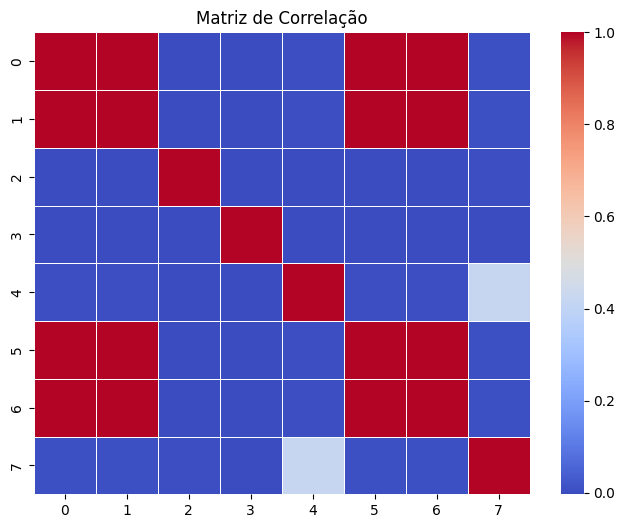

In [47]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix.toArray(), cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
# remoção de duplicados e valores nulos
df_clean = df.dropDuplicates()
df_clean = df_clean.dropna()
df_clean = df_clean.drop("TX_DATETIME")

In [ ]:
from pyspark.sql.functions import when, lit

#  "TX_FRAUD" é 0 (não fraude) ou 1 (fraude)
count_total = df_clean.count()
count_fraude = df_clean.filter(df_clean.TX_FRAUD == 1).count()
count_nao_fraude = count_total - count_fraude

# Peso para fraudes
fraude_weight = count_nao_fraude / count_fraude

# Cria a coluna "classWeightCol"
df_weighted = df_clean.withColumn(
    "classWeightCol",
    when(df_clean.TX_FRAUD == 1, fraude_weight).otherwise(1.0)
)

In [33]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

feature_cols = [col for col in df_weighted.columns if col not in ["TX_FRAUD", "classWeightCol"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

In [34]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="scaledFeatures",
    labelCol="TX_FRAUD",
    weightCol="classWeightCol",  # para lidar com desbalanceamento
    maxIter=10
)

In [35]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, scaler, lr])

# Divide em treino e teste
train_df, test_df = df_weighted.randomSplit([0.7, 0.3], seed=42)

# Treina o modelo
model = pipeline.fit(train_df)

In [38]:
predictions = model.transform(test_df)

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD",
    rawPredictionCol="prediction",  # ou "rawPrediction", dependendo do modelo
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)
print(f"AUC = {auc:.4f}")

# Para outras métricas (Precision/Recall), podemos usar o MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

precision_eval = MulticlassClassificationEvaluator(
    labelCol="TX_FRAUD", 
    predictionCol="prediction", 
    metricName="precisionByLabel"  # ou "recallByLabel", "f1"
)
precision = precision_eval.evaluate(predictions)
print(f"Precision = {precision:.4f}")

AUC = 1.0000
Precision = 1.0000
